In [67]:
import numpy as np
import pandas as pd

train_test_split() : 학습/테스트 데이터 세트 분리

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer, TFBertForSequenceClassification

2024-01-17 12:57:38.063256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 12:57:38.184556: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 12:57:39.356585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-01-17 12:57:39.356662: W tensorflow/

In [3]:
# 경고를 무시함
import warnings
warnings.filterwarnings('ignore')

In [13]:
# 데이터 읽어오기
df = pd.read_csv("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", delimiter=',')
 
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [15]:
df_need = df[df.label != 0]

In [29]:
df_shuffled = df_need.sample(frac=1).reset_index(drop=True)  # 행 섞기
df_shuffled.head() # 확인용 출력

,Q,A,label
0,사랑 글로 배워요,글로라도 배우세요.,2
1,좋아하는 오빠가 최근에 연락이 계속 늦거나 이어지지 않는데 그냥 연락 끊어야 할까.,그러는 것이 맘 편할지도 몰라요.,2
2,여사친인데 좋아하는 듯.,친구와 썸의 중간인 거 같아요.,2
3,여자인데 먼저 대쉬해도 됨?,여자가 먼저 대쉬하면 더 매력있죠.,2
4,잘가,안녕.,1


In [17]:
df_shuffled = df_shuffled.loc[:, ['Q', 'label']]

In [27]:
df_shuffled['label'] = df_shuffled['label'] + 1

In [36]:
df_shuffled.loc[:, 'label'] = df_shuffled.loc[:, 'label'] - 1

In [38]:
max(list(df_shuffled['label']))

1

In [39]:
df_shuffled.head()

,Q,A,label
0,사랑 글로 배워요,글로라도 배우세요.,1
1,좋아하는 오빠가 최근에 연락이 계속 늦거나 이어지지 않는데 그냥 연락 끊어야 할까.,그러는 것이 맘 편할지도 몰라요.,1
2,여사친인데 좋아하는 듯.,친구와 썸의 중간인 거 같아요.,1
3,여자인데 먼저 대쉬해도 됨?,여자가 먼저 대쉬하면 더 매력있죠.,1
4,잘가,안녕.,0


In [41]:
df_shuffled['label'].values

array([1, 1, 1, ..., 1, 0, 1])

In [42]:
df = df_shuffled #최종 확인 후 덮어쓰기

In [48]:
df.head()

,Q,label
0,사랑 글로 배워요,1
1,좋아하는 오빠가 최근에 연락이 계속 늦거나 이어지지 않는데 그냥 연락 끊어야 할까.,1
2,여사친인데 좋아하는 듯.,1
3,여자인데 먼저 대쉬해도 됨?,1
4,잘가,0


In [45]:
df['label']

0       1
1       1
2       1
3       1
4       0
       ..
6528    1
6529    0
6530    1
6531    0
6532    1
Name: label, Length: 6533, dtype: int64

In [46]:
labels = df['label'].values

In [50]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df['Q'], labels, random_state=42, test_size=0.2)

### 토큰화

In [57]:
# 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [59]:
def encode(data, tokenizer):
    input_ids = []
    attention_masks = []
    token_type_ids = []
 
    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=50,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                              truncation=True)
        
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])
    
    return input_ids, attention_masks, token_type_ids

In [60]:
#학습데이터 토큰화
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer)
 
#테스트데이터 토큰화
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer)

### 데이터 형태 변경

Bert에 입력하기 위해 데이터 형태를 딕셔너리로 변경

In [62]:
#딕셔너리 형태로 변환해서 출력 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label
      
 #데이터를 BERT에 넣을 수 있는 형태로 변경 
def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [64]:
BATCH_SIZE = 32
 
#학습 데이터
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).shuffle(10000).batch(BATCH_SIZE)
 
#평가 데이터
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)

### 모델 학습

In [71]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = 2,
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
model

In [73]:
optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
NUM_EPOCHS = 10
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

Epoch 1/10
164/164 [==============================] - 95s 314ms/step - loss: 0.3595 - accuracy: 0.8467 - val_loss: 0.2254 - val_accuracy: 0.9112
Epoch 2/10
164/164 [==============================] - 45s 271ms/step - loss: 0.2009 - accuracy: 0.9252 - val_loss: 0.2224 - val_accuracy: 0.9158
Epoch 3/10
164/164 [==============================] - 44s 269ms/step - loss: 0.1484 - accuracy: 0.9493 - val_loss: 0.2260 - val_accuracy: 0.9197
Epoch 4/10
164/164 [==============================] - 44s 267ms/step - loss: 0.1074 - accuracy: 0.9625 - val_loss: 0.2323 - val_accuracy: 0.9197
Epoch 5/10
164/164 [==============================] - 44s 268ms/step - loss: 0.0843 - accuracy: 0.9717 - val_loss: 0.2519 - val_accuracy: 0.9166
Epoch 6/10
164/164 [==============================] - 44s 266ms/step - loss: 0.0693 - accuracy: 0.9772 - val_loss: 0.2313 - val_accuracy: 0.9258
Epoch 7/10
164/164 [==============================] - 44s 266ms/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.2700 - val_ac

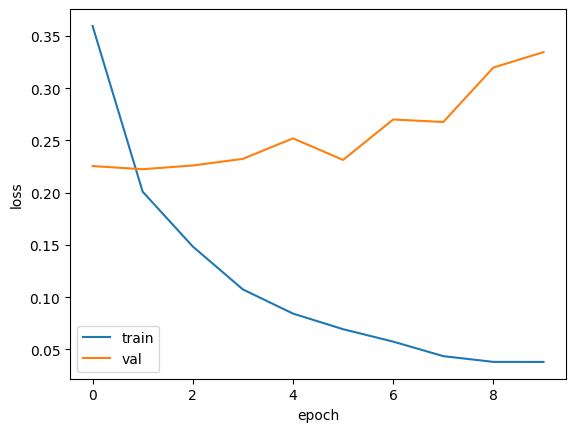

In [74]:
#loss 확인
 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [76]:
model.save_pretrained('guru.h5')